# Analysis of variant loss after thresholding by counts in no-antibody selections



Import Python modules:

In [1]:
import os

import altair as alt

import dms_variants
import dms_variants.codonvarianttable
from dms_variants.constants import CBPALETTE
import dms_variants.plotnine_themes

from plotnine import *

_ = theme_set(dms_variants.plotnine_themes.theme_graygrid())

import pandas as pd

import yaml

In [2]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

Get configuration information:

In [3]:
os.chdir('../../')

with open("config.yaml") as f:
    config = yaml.safe_load(f)

## Read the escape probabilities and neutralization information
Get the antibody selections data frame:

In [4]:
antibody_selections = pd.read_csv(config["antibody_selections"])

Read in the probabilities of escape and neutralization information:

In [5]:
selection_groups = antibody_selections["selection_group"].unique()

prob_escape = pd.concat(
    [
        pd.read_csv(
            os.path.join(
                config["prob_escape_dir"], f"{selection_group}_prob_escape.csv"
            ),
            keep_default_na=False,
            na_values="nan",
        )
        for selection_group in selection_groups
    ],
    ignore_index=True,
)

## Variants with sufficient no-antibody counts
We only calculate the probability of escape for variants with some minimum threshold of no-antibody counts.

Get a df of samples for each selection and label whether they pass the minimum threshold for their corresponding no-antibody sample

In [6]:
# get data to plot
no_ab_counts = (
    prob_escape[
        [
            "library",
            "no-antibody_sample",
            "aa_substitutions_sequential",
            "no-antibody_count",
            "barcode",
            "no_antibody_count_threshold",
        ]
    ]
    .drop_duplicates()
    .assign(
        variant_above_threshold=lambda x: (
            x["no-antibody_count"] >= x["no_antibody_count_threshold"]
        ).astype(int),
        count_above_threshold=lambda x: x["no-antibody_count"]
        * x["variant_above_threshold"],
    ))

no_ab_counts['sample'] = no_ab_counts['library'] + '_' + no_ab_counts['no-antibody_sample']

### Analyze low-count variants from 220606 selection samples

In [10]:
# get a df that only has barcodes counts from the 220606_no-antibody-control
no_ab_220606 = no_ab_counts.loc[(no_ab_counts['sample'] == 'libA_220606_1_no-antibody_control_1') |
                                (no_ab_counts['sample'] == 'libB_220606_1_no-antibody_control_1')
                               ].reset_index(drop=True)

# count the total number of variants, the number below the 20 count threshold, and the number with 0 counts
# just add everything to a dict for now
libs = ['libA', 'libB']
lib_var_counts = {}

for lib in libs:
    lib_no_ab = no_ab_220606.loc[(no_ab_220606['library'] == lib)]
    lib_var_counts[f'{lib}_variants'] = len(lib_no_ab.index)
    lib_var_counts[f'{lib}_below_threshold'] = len(lib_no_ab.loc[lib_no_ab['variant_above_threshold'] == 0].index)
    lib_var_counts[f'{lib}_zero'] = len(lib_no_ab.loc[lib_no_ab['no-antibody_count'] == 0].index)
    
#     number_variants = len(lib_no_ab.index)
#     number_below_threshold = len(lib_no_ab.loc[lib_no_ab['variant_above_threshold'] == 0].index)
#     number_zero = len(lib_no_ab.loc[lib_no_ab['no-antibody_count'] == 0].index)

# libA_passage_data = [number_variants, number_below_threshold, number_zero, 'libA']

# print(f'Unique variants from PacBio sequencing of plasmid library: {number_variants}')
# print(f'Variants with less than 20 counts in no Ab infections: {number_below_threshold}')
# print(f'Variants with 0 counts in no Ab infections: {number_zero}')

lib_var_counts

{'libA_variants': 66581,
 'libA_below_threshold': 47144,
 'libA_zero': 17456,
 'libB_variants': 85134,
 'libB_below_threshold': 67729,
 'libB_zero': 32557}

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: scratch_notebooks/220614_variant_dropout_analysis/figures/counts_below_threshold_dist.pdf


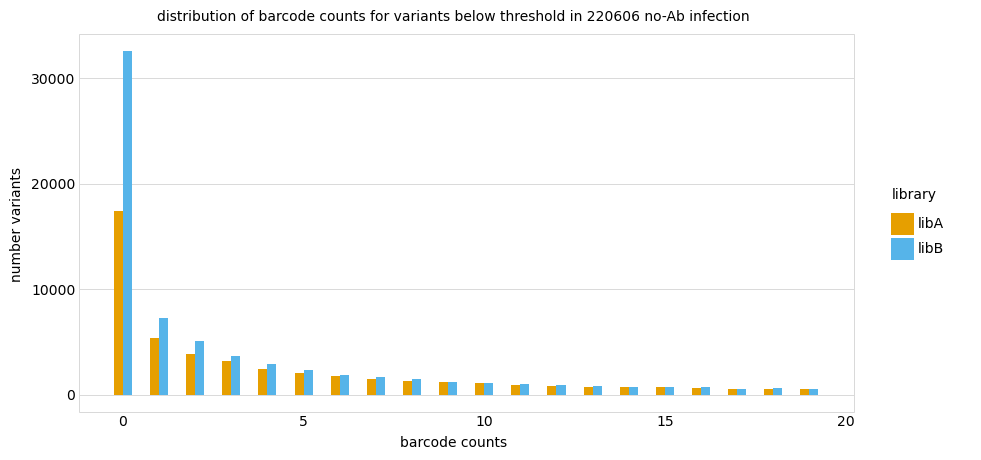

In [22]:
# plot the distribution of counts for variants below the threshold

no_ab_220606_threshold = (no_ab_220606.loc[no_ab_220606['variant_above_threshold'] == 0].reset_index(drop=True))

p = (
    ggplot(
        no_ab_220606_threshold,
        aes(x='no-antibody_count', fill='library')) + 
    geom_histogram(position=position_dodge(), binwidth=0.5) + 
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    scale_fill_manual(values=CBPALETTE[1:]) +
    labs(x='barcode counts', 
         y='number variants', title='distribution of barcode counts for variants below threshold in 220606 no-Ab infection')
) 

_ = p.draw()

p.save('scratch_notebooks/220614_variant_dropout_analysis/figures/counts_below_threshold_dist.pdf')

So for the 220606 no-Ab samples, around 70% of variants are getting filtered out because the counts are too low. But note that number variants is based on sequencing of the plasmid library, and around 30% of the dropouts have *0 counts* in infections with the passaged library. If variant loss was mainly due to bottlenecking or low sequencing depth, we might expect to see more variants with 1 or 2 barcode counts, rather than the sharp drop from 0 to 1 shown here.

On this 220606 run, I also infected cells with the rescued libraries and sequenced. Check whether variants with 0 counts in the passaged library infections are also missing from the rescued libraries:

In [25]:
libA_rescue_counts = pd.read_csv('results/variant_counts/libA_220606_1_no-VEP_control_rescue.csv')
libA_rescue_counts['library'] = 'libA'

libB_rescue_counts = pd.read_csv('results/variant_counts/libB_220606_1_no-VEP_control_rescue.csv')
libB_rescue_counts['library'] = 'libB'

rescue_counts = pd.concat([libA_rescue_counts, libB_rescue_counts])
rescue_counts

,barcode,count,codon_substitutions,aa_substitutions,variant_call_support,library
0,AGACACTAAATACAGC,52679,TAC113AAT ACT150AAA TTG263CAT GTA342TAT,Y113N T150K L263H V342Y,5,libA
1,ATAACACAAAAAAGTA,52219,AAG297ATA,K297I,4,libA
2,CCTTACGCGATAGGTG,28804,AGC28ACA AGA111AAC ATA261ATG GAA462TTT,S28T R111N I261M E462F,6,libA
3,AAAAATCTGAGACAAA,27526,AAA46GCA ATC301GTG GAG409ATG,K46A I301V E409M,4,libA
4,AGCCTATTAGGATTCG,23468,NaN,NaN,5,libA
...,...,...,...,...,...,...
85133,TTTTTGGTTTATGTAT,0,AAT50TAT AGT164AAA CAA216CTC TCA217ATG,N50Y S164K Q216L S217M,3,libB
85134,TTTTTGTGGGGTCTTC,0,GTT107ATA ACA179TTC TCT238CAA,V107I T179F S238Q,2,libB
85135,TTTTTTATATATGTTG,0,ATC211TTT CTT447ATA,I211F L447I,3,libB
85136,TTTTTTCGATAGTCCT,0,TCT157TTC GGA161TCG TCC212GGA AGA239TTT,S157F G161S S212G R239F,4,libB


Note that this dataframe has 4 extra variants for each lib which are the 4 neut standard barcodes.

In [30]:
# generate df of passaged lib variants matched to their counts in seq of the rescued lib
# use right merge to get rid of the 4 extra neut standard barcodes in the rescue seq df
passage_rescue_merged = rescue_counts.merge(
    no_ab_220606,
    on='barcode',
    how='right',
    suffixes=('_rescue', '_no_ab')
)

# reduce to just the columns we care about
passage_rescue_merged = passage_rescue_merged[[
    'barcode', 'count', 'aa_substitutions', 'no-antibody_count', 'sample', 'library_rescue'
]]

passage_rescue_merged = passage_rescue_merged.rename(columns={
    'count': 'rescue_count',
    'no-antibody_count': 'passaged_count',
    'library_rescue': 'library'
})

# coerce this column from floats back to int
passage_rescue_merged['passaged_count'] = passage_rescue_merged['passaged_count'].astype(int)

libs = ['libA', 'libB']
# # count the number of variants with 0 counts in passaged and rescued libs
# zero_count_both = len(passage_rescue_merged_libA.loc[(passage_rescue_merged_libA['rescue_count'] == 0) & 
#                                                 (passage_rescue_merged_libA['passaged_count'] == 0)
#                                                ].index)

# zero_count_either = len(passage_rescue_merged_libA.loc[(passage_rescue_merged_libA['rescue_count'] == 0) | 
#                                                 (passage_rescue_merged_libA['passaged_count'] == 0)
#                                                ].index)


# zero_count_rescue_only = len(passage_rescue_merged_libA.loc[(passage_rescue_merged_libA['rescue_count'] == 0) & 
#                                                 (passage_rescue_merged_libA['passaged_count'] != 0)
#                                                ].index)

# zero_count_passage_only = len(passage_rescue_merged_libA.loc[(passage_rescue_merged_libA['rescue_count'] != 0) & 
#                                                 (passage_rescue_merged_libA['passaged_count'] == 0)
#                                                ].index)

# print(f'Variants with 0 counts in either the rescued or passaged lib: {zero_count_either}')
# print(f'Variants with 0 counts in both the rescued and passaged libs: {zero_count_both}')
# print(f'Variants with 0 counts in the rescue, that are seen in the passaged lib: {zero_count_rescue_only}')
# print(f'Variants that are seen in the rescued lib but have 0 counts in the passaged: {zero_count_passage_only}')

,barcode,rescue_count,aa_substitutions,passaged_count,sample,library
0,ATAACACAAAAAAGTA,52219,K297I,95250,libA_220606_1_no-antibody_control_1,libA
1,AGACACTAAATACAGC,52679,Y113N T150K L263H V342Y,28477,libA_220606_1_no-antibody_control_1,libA
2,AAAAATCTGAGACAAA,27526,K46A I301V E409M,28101,libA_220606_1_no-antibody_control_1,libA
3,AGCCTATTAGGATTCG,23468,NaN,27169,libA_220606_1_no-antibody_control_1,libA
4,TATCTACCTAACGAAA,11119,R111S V366M R402S,24512,libA_220606_1_no-antibody_control_1,libA
...,...,...,...,...,...,...
151712,TTTTTTGATTACCAGC,30,V45I D209Y I211T R280H T337V K387R S419P K491S...,3,libB_220606_1_no-antibody_control_1,libB
151713,TTTTTTTAAGACAAAC,3,N152S H175A I211D Q216S K297F D310Q,0,libB_220606_1_no-antibody_control_1,libB
151714,TTTTTTTAGGCAATAA,5,Q216D S217C,0,libB_220606_1_no-antibody_control_1,libB
151715,TTTTTTTTCCACTAAA,0,K295N D310M,0,libB_220606_1_no-antibody_control_1,libB


This last number is the most interesting, and suggests that significant bottlenecking may have occurred during passaging. There are a handful of variants (610) that were not sequenced in the rescued library, but showed up in the passaged library, which means they were likely missed due to low sequencing coverage or a low sample size in the rescue infections. However, **13,118 variants** were sequenced at the rescue stage and then dropped out after library passaging.

Take these 13k variants and visualize the distribution of their counts in the rescued library. Were they all at low frequency?

In [12]:
passage_dropouts = (passage_rescue_merged.loc[(passage_rescue_merged_libA['rescue_count'] != 0) & 
                                                (passage_rescue_merged['passaged_count'] == 0)
                                               ].reset_index(drop=True))

p = (
    ggplot(
        passage_dropouts,
        aes(x='rescue_count')) + 
    geom_histogram(binwidth=1) + 
    geom_vline(aes(xintercept=10)) +
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    labs(x='barcode counts in lib rescue sequencing', 
         y='number variants', title='220606_libA variants sequenced in rescued but not passaged lib infections')
) 

_ = p.draw()

p.save('scratch_notebooks/220614_pool_selections/figures/libA_rescue_dropouts.pdf')

NameError: name 'passage_rescue_merged' is not defined

Check the 90th percentile frequency if we remove all 0-count variants:

In [26]:
libA_sequenced_vars

,barcode,rescue_count,aa_substitutions,passaged_count,sample,library,percent
0,ATAACACAAAAAAGTA,52219,K297I,95250,libA_220606_1_no-antibody_control_1,libA,2.355750
1,AGACACTAAATACAGC,52679,Y113N T150K L263H V342Y,28477,libA_220606_1_no-antibody_control_1,libA,0.704301
2,AAAAATCTGAGACAAA,27526,K46A I301V E409M,28101,libA_220606_1_no-antibody_control_1,libA,0.695002
3,AGCCTATTAGGATTCG,23468,NaN,27169,libA_220606_1_no-antibody_control_1,libA,0.671951
4,TATCTACCTAACGAAA,11119,R111S V366M R402S,24512,libA_220606_1_no-antibody_control_1,libA,0.606238
...,...,...,...,...,...,...,...
49120,TTTTTACATCAGTTAA,18,S65R Q151V Q216F Q330K L450F,1,libA_220606_1_no-antibody_control_1,libA,0.000025
49121,TTTTTAGATAAAAGTA,4,P181L K226R L458W,1,libA_220606_1_no-antibody_control_1,libA,0.000025
49122,TTTTTAGATAGGTGAG,21,C33F K102C Y178H T179Y,1,libA_220606_1_no-antibody_control_1,libA,0.000025
49123,TTTTTTCATGCATAGA,10,N25K E69S F98I Q216T R326K S377C T435S S461D,5,libA_220606_1_no-antibody_control_1,libA,0.000124


In [23]:
libA_sequenced_vars['percent'] = 100 * libA_sequenced_vars['passaged_count'] / libA_sequenced_vars.groupby('sample')['passaged_count'].transform('sum')

In [27]:
# libA_sequenced_vars = passage_rescue_merged_libA.loc[
#     passage_rescue_merged_libA['passaged_count'] != 0].reset_index(drop=True)

# libA_sequenced_vars = libA_sequenced_vars.assign(
#     percent=lambda x: 100
#     * x['passaged_count'] 
#     / x.groupby(['sample']).transform('sum')
# )

# libA_sequenced_vars['percent'] = 100 * libA_sequenced_vars['passaged_count'] / libA_sequenced_vars['passaged_count'].transform('sum')

libA_sequenced_vars_quantiles = (libA_sequenced_vars
                                 .aggregate(
                                     percentile_10 = pd.NamedAgg("percent", lambda s: s.quantile(0.1)),
                                     percentile_90=pd.NamedAgg("percent", lambda s: s.quantile(0.9)),
                                     min_percent=pd.NamedAgg("percent", "min"),
                                     max_percent=pd.NamedAgg("percent", "max"),
                                 )
                                )


# .assign(
#         percent=lambda x: 100
#         * x["count"]
#         / x.groupby(["library_sample", "target"])["count"].transform("sum")
#     )
#     .sort_values("percent", ascending=False)
libA_sequenced_vars_quantiles

,percent
percentile_10,0.000025
percentile_90,0.003561
min_percent,0.000025
max_percent,2.355750


In [ ]:
libA_sequenced_vars_quantiles = (libA_sequenced_vars
                                 .aggregate(
                                     percentile_10 = pd.NamedAgg("percent", lambda s: s.quantile(0.1)),
                                     percentile_90=pd.NamedAgg("percent", lambda s: s.quantile(0.9)),
                                     min_percent=pd.NamedAgg("percent", "min"),
                                     max_percent=pd.NamedAgg("percent", "max"),
                                 )
                                )

In [ ]:
top_n = 25

variant_counts_top_n = (
    variant_counts.groupby(["library_sample", "target"])
    .head(n=top_n)
    .merge(
        (
            variant_counts.groupby(
                ["library_sample", "target"], as_index=False
            ).aggregate(
                percentile_10=pd.NamedAgg("percent", lambda s: s.quantile(0.1)),
                percentile_90=pd.NamedAgg("percent", lambda s: s.quantile(0.9)),
                min_percent=pd.NamedAgg("percent", "min"),
                max_percent=pd.NamedAgg("percent", "max"),
            )
        ),
        validate="many_to_one",
    )
)

variant_counts_top_n.head()

In [ ]:
len(passage_dropouts.loc[passage_dropouts['rescue_count'] >= 10].index)

Most of the dropout variants were at very low counts. ~4600 variants had appreciable counts (at least 10) in the rescue seq and were then lost. But I don't think bottlenecking out 4k variants is enough to justify re-passaging the libraries.

Repeat this analysis with libB to see if there's a comparable rate of dropout after passaging:

In [14]:
# get a df that only has barcodes counts from the 220606_no-antibody-control
libB_220606_no_ab = no_ab_counts.loc[no_ab_counts['sample'] == 'libB_220606_1_no-antibody_control_1'
                                     ].reset_index(drop=True)

# count the total number of variants, the number below the 20 count threshold, and the number with 0 counts
number_variants = len(libB_220606_no_ab.index)
number_below_threshold = len(libB_220606_no_ab.loc[libB_220606_no_ab['variant_above_threshold'] == 0].index)
number_zero = len(libB_220606_no_ab.loc[libB_220606_no_ab['no-antibody_count'] == 0].index)

libB_passage_data = [number_variants, number_below_threshold, number_zero, 'libB']

print(f'Unique variants from PacBio sequencing of plasmid library: {number_variants}')
print(f'Variants with less than 20 counts in no Ab infections: {number_below_threshold}')
print(f'Variants with 0 counts in no Ab infections: {number_zero}')

Unique variants from PacBio sequencing of plasmid library: 85134
Variants with less than 20 counts in no Ab infections: 67729
Variants with 0 counts in no Ab infections: 32557


In [15]:
column_headers = ['pacbio_total', 'below_count_threshold', 'zero_counts', 'library']

lists = pd.Series([column_headers, libA_passage_data, libB_passage_data])

passage_data = pd.DataFrame(item for item in lists)
passage_data = passage_data.rename(columns=passage_data.iloc[0]).drop(passage_data.index[0])



passage_data

,pacbio_total,below_count_threshold,zero_counts,library
1,66581,47144,17456,libA
2,85134,67729,32557,libB


In [16]:
passage_data_tidy = passage_data.melt(
    id_vars = ['library'], 
    value_vars = ['pacbio_total', 'below_count_threshold', 'zero_counts'],
    var_name = 'variant_category',
    value_name = 'number_variants'
)

passage_data_tidy['number_variants'] = passage_data_tidy['number_variants'].astype(int)

In [17]:
passage_data_tidy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   library           6 non-null      object
 1   variant_category  6 non-null      object
 2   number_variants   6 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 272.0+ bytes


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: scratch_notebooks/220614_pool_selections/figures/passaged_variant_counts.pdf


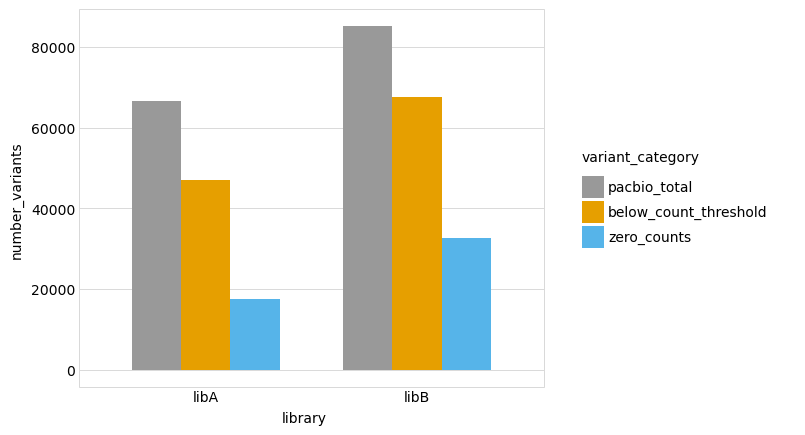

In [18]:
passage_data_tidy['variant_category'] = pd.Categorical(
    passage_data_tidy['variant_category'], categories=['pacbio_total', 'below_count_threshold', 'zero_counts'], ordered=True
)

p = (
    ggplot(
        passage_data_tidy,
        aes(x='library', y='number_variants', fill='variant_category')
    ) +
    geom_bar(stat='identity', position=position_dodge(), width=0.7) +
    theme(figure_size=(6, 5),
         panel_grid_major_x=element_blank(),
         ) + 
    scale_fill_manual(values=CBPALETTE)
)

_ = p.draw()

p.save('scratch_notebooks/220614_pool_selections/figures/passaged_variant_counts.pdf')

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 97'. Pick better value with 'binwidth'.


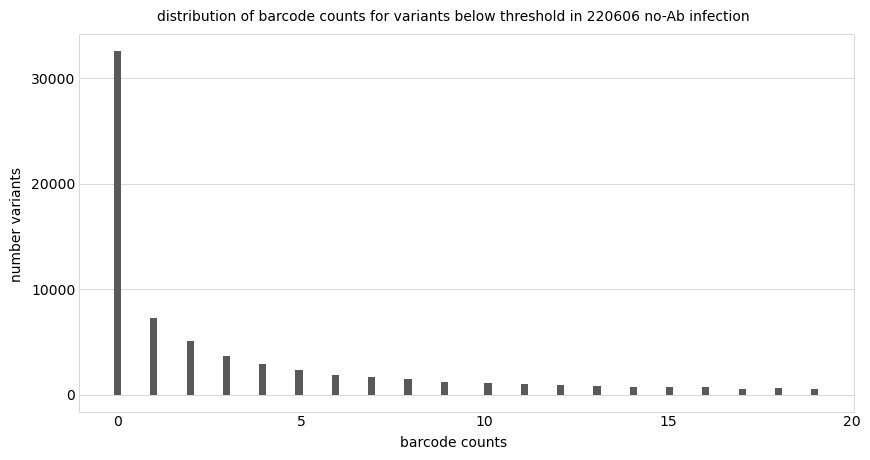

In [19]:
# plot the distribution of counts for variants below the threshold

libB_220606_no_ab_threshold = (libB_220606_no_ab.loc[libB_220606_no_ab['variant_above_threshold'] == 0]
                               .reset_index(drop=True))

p = (
    ggplot(
        libB_220606_no_ab_threshold,
        aes(x='no-antibody_count')) + 
    geom_histogram() + 
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    labs(x='barcode counts', 
         y='number variants', title='distribution of barcode counts for variants below threshold in 220606 no-Ab infection')
) 

_ = p.draw()

So for this 220606_libA_no-Ab sample, around 70% of variants are getting filtered out because the counts are too low. But note that number variants is based on sequencing of the plasmid library, and 17,456 variants have *0 counts* in infections with the passaged library. So it actually looks like we're losing 25% of library variants due to functional selection, not bottlenecking or low sequencing depth. 

On this 220606 run, I also infected cells with the rescued libraries and sequenced. Check whether variants with 0 counts in the passaged library infections are also missing from the rescued libraries:

In [12]:
libB_rescue_counts = pd.read_csv('results/variant_counts/libB_220606_1_no-VEP_control_rescue.csv')
libB_rescue_counts

,barcode,count,codon_substitutions,aa_substitutions,variant_call_support
0,TAACCTCAGTCAACAA,20692,NaN,NaN,8
1,CGTCTCCACACAATTA,13976,CCC308TCA,P308S,5
2,AAACAAATTGTTAGGA,13530,NaN,NaN,9
3,AATAATAGGTGAGTCT,13282,CCG122GAT AGA220GCA AGA239GCA TTA515ATA,P122D R220A R239A L515I,3
4,TAACGAGGTCTAATCA,13002,CAG76ATG TTG263ATG,Q76M L263M,6
...,...,...,...,...,...
85133,TTTTTGGTTTATGTAT,0,AAT50TAT AGT164AAA CAA216CTC TCA217ATG,N50Y S164K Q216L S217M,3
85134,TTTTTGTGGGGTCTTC,0,GTT107ATA ACA179TTC TCT238CAA,V107I T179F S238Q,2
85135,TTTTTTATATATGTTG,0,ATC211TTT CTT447ATA,I211F L447I,3
85136,TTTTTTCGATAGTCCT,0,TCT157TTC GGA161TCG TCC212GGA AGA239TTT,S157F G161S S212G R239F,4


Note that this dataframe has 4 extra variants which are the 4 neut standard barcodes.

In [13]:
# generate df of passaged lib variants matched to their counts in seq of the rescued lib
# use right merge to get rid of the 4 extra neut standard barcodes in the rescue seq df
passage_rescue_merged = libB_rescue_counts.merge(
    libB_220606_no_ab,
    on='barcode',
    how='right',
    suffixes=('rescue', 'no_ab')
)

# reduce to just the columns we care about
passage_rescue_merged = passage_rescue_merged[[
    'barcode', 'count', 'aa_substitutions', 'no-antibody_count', 'sample'
]]

passage_rescue_merged = passage_rescue_merged.rename(columns={
    'count': 'rescue_count',
    'no-antibody_count': 'passaged_count'
})

# coerce this column from floats back to int
passage_rescue_merged['passaged_count'] = passage_rescue_merged['passaged_count'].astype(int)

# count the number of variants with 0 counts in passaged and rescued libs
zero_count_both = len(passage_rescue_merged.loc[(passage_rescue_merged['rescue_count'] == 0) & 
                                                (passage_rescue_merged['passaged_count'] == 0)
                                               ].index)

zero_count_either = len(passage_rescue_merged.loc[(passage_rescue_merged['rescue_count'] == 0) | 
                                                (passage_rescue_merged['passaged_count'] == 0)
                                               ].index)


zero_count_rescue_only = len(passage_rescue_merged.loc[(passage_rescue_merged['rescue_count'] == 0) & 
                                                (passage_rescue_merged['passaged_count'] != 0)
                                               ].index)

zero_count_passage_only = len(passage_rescue_merged.loc[(passage_rescue_merged['rescue_count'] != 0) & 
                                                (passage_rescue_merged['passaged_count'] == 0)
                                               ].index)

print(f'Variants with 0 counts in either the rescued or passaged lib: {zero_count_either}')
print(f'Variants with 0 counts in both the rescued and passaged libs: {zero_count_both}')
print(f'Variants with 0 counts in the rescue, that are seen in the passaged lib: {zero_count_rescue_only}')
print(f'Variants that are seen in the rescued lib but have 0 counts in the passaged: {zero_count_passage_only}')

NameError: name 'libB_220606_no_ab' is not defined

This last number is the most interesting, and suggests that significant bottlenecking may have occurred during passaging. There are a handful of variants (610) that were not sequenced in the rescued library, but showed up in the passaged library, which means they were likely missed due to low sequencing coverage or a low sample size in the rescue infections. However, **13,118 variants** were sequenced at the rescue stage and then dropped out after library passaging.

Take these 13k variants and visualize the distribution of their counts in the rescued library. Were they all at low frequency?

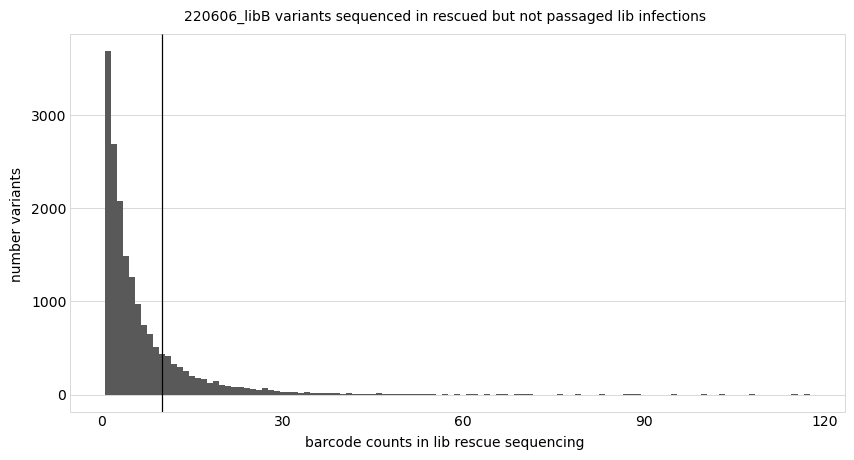

In [22]:
passage_dropouts = (passage_rescue_merged.loc[(passage_rescue_merged['rescue_count'] != 0) & 
                                                (passage_rescue_merged['passaged_count'] == 0)
                                               ].reset_index(drop=True))

p = (
    ggplot(
        passage_dropouts,
        aes(x='rescue_count')) + 
    geom_histogram(binwidth=1) + 
    geom_vline(aes(xintercept=10)) +
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    labs(x='barcode counts in lib rescue sequencing', 
         y='number variants', title='220606_libB variants sequenced in rescued but not passaged lib infections')
) 

_ = p.draw()

# p.save('scratch_notebooks/220614_pool_selections/figures/libB_rescue_dropouts.pdf')

In [ ]:
len(passage_dropouts.loc[passage_dropouts['rescue_count'] >= 10].index)

### Stratifying on number of mutations
How many variants have sufficient counts out of -
* wildtype variants
* variants with synonymous mutations
* 1 AA mutants
* 2 AA mutants

If variants are dropping out after passaging due to functional selection, we would expect this to be acting more strongly on variants with increasing numbers of mutations. 

In [15]:
passage_rescue_merged_libA = libA_rescue_counts.merge(
    libA_220606_no_ab,
    on='barcode',
    how='right',
    suffixes=('rescue', 'no_ab')
)

passage_rescue_merged_libB = libB_rescue_counts.merge(
    libB_220606_no_ab,
    on='barcode',
    how='right',
    suffixes=('rescue', 'no_ab')
)

passage_rescue_merged = pd.concat([passage_rescue_merged_libA, passage_rescue_merged_libB])

# reduce to just the columns we care about
passage_rescue_merged = passage_rescue_merged[[
    'barcode', 'count', 'aa_substitutions', 'no-antibody_count', 'library'
]]

passage_rescue_merged = passage_rescue_merged.rename(columns={
    'count': 'rescue_count',
    'no-antibody_count': 'passaged_count'
})

# coerce this column from floats back to int
passage_rescue_merged['passaged_count'] = passage_rescue_merged['passaged_count'].astype(int)

passage_rescue_merged

,barcode,rescue_count,aa_substitutions,passaged_count,library
0,ATAACACAAAAAAGTA,52219,K297I,95250,libA
1,AGACACTAAATACAGC,52679,Y113N T150K L263H V342Y,28477,libA
2,AAAAATCTGAGACAAA,27526,K46A I301V E409M,28101,libA
3,AGCCTATTAGGATTCG,23468,NaN,27169,libA
4,TATCTACCTAACGAAA,11119,R111S V366M R402S,24512,libA
...,...,...,...,...,...
85129,TTTTTTGATTACCAGC,30,V45I D209Y I211T R280H T337V K387R S419P K491S...,3,libB
85130,TTTTTTTAAGACAAAC,3,N152S H175A I211D Q216S K297F D310Q,0,libB
85131,TTTTTTTAGGCAATAA,5,Q216D S217C,0,libB
85132,TTTTTTTTCCACTAAA,0,K295N D310M,0,libB


In [24]:

passage_rescue_merged

,barcode,rescue_count,aa_substitutions,passaged_count,library,number_substitutions,pacbio_count
0,ATAACACAAAAAAGTA,52219,K297I,95250,libA,1,1
1,AGACACTAAATACAGC,52679,Y113N T150K L263H V342Y,28477,libA,4,1
2,AAAAATCTGAGACAAA,27526,K46A I301V E409M,28101,libA,3,1
3,AGCCTATTAGGATTCG,23468,,27169,libA,0,1
4,TATCTACCTAACGAAA,11119,R111S V366M R402S,24512,libA,3,1
...,...,...,...,...,...,...,...
85129,TTTTTTGATTACCAGC,30,V45I D209Y I211T R280H T337V K387R S419P K491S...,3,libB,9,1
85130,TTTTTTTAAGACAAAC,3,N152S H175A I211D Q216S K297F D310Q,0,libB,6,1
85131,TTTTTTTAGGCAATAA,5,Q216D S217C,0,libB,2,1
85132,TTTTTTTTCCACTAAA,0,K295N D310M,0,libB,2,1


In [ ]:
passage_rescue_merged = passage_rescue_merged.fillna('')

passage_rescue_merged['number_substitutions'] = passage_rescue_merged.apply(
    lambda x: len(x['aa_substitutions'].split()), axis=1
)

passage_rescue_merged['pacbio_count'] = 1

lib_counts_tidy = passage_rescue_merged.melt(
    id_vars = ['barcode', 'aa_substitutions', 'number_substitutions', 'library'],
    value_vars = ['rescue_count', 'passaged_count', 'pacbio_count'],
    var_name = 'sample',
    value_name = 'count'
)

lib_counts_tidy

In [29]:
sufficient_counts = lib_counts_tidy.loc[(lib_counts_tidy['count'] >= 20) | 
                                        (lib_counts_tidy['sample'] == 'pacbio_count')].reset_index(drop=True)

stratified_thresholded_variants = (sufficient_counts.groupby(['number_substitutions', 'sample', 'library'])
                                   .size()
                                   .reset_index(name='thresholded_variants'))

stratified_thresholded_variants.head()

,number_substitutions,sample,library,thresholded_variants
0,0,pacbio_count,libA,2244
1,0,pacbio_count,libB,4597
2,0,passaged_count,libA,1314
3,0,passaged_count,libB,1845
4,0,rescue_count,libA,1658


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 7 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: scratch_notebooks/220614_pool_selections/figures/thresholded_variant_distribution_pacbio.pdf
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


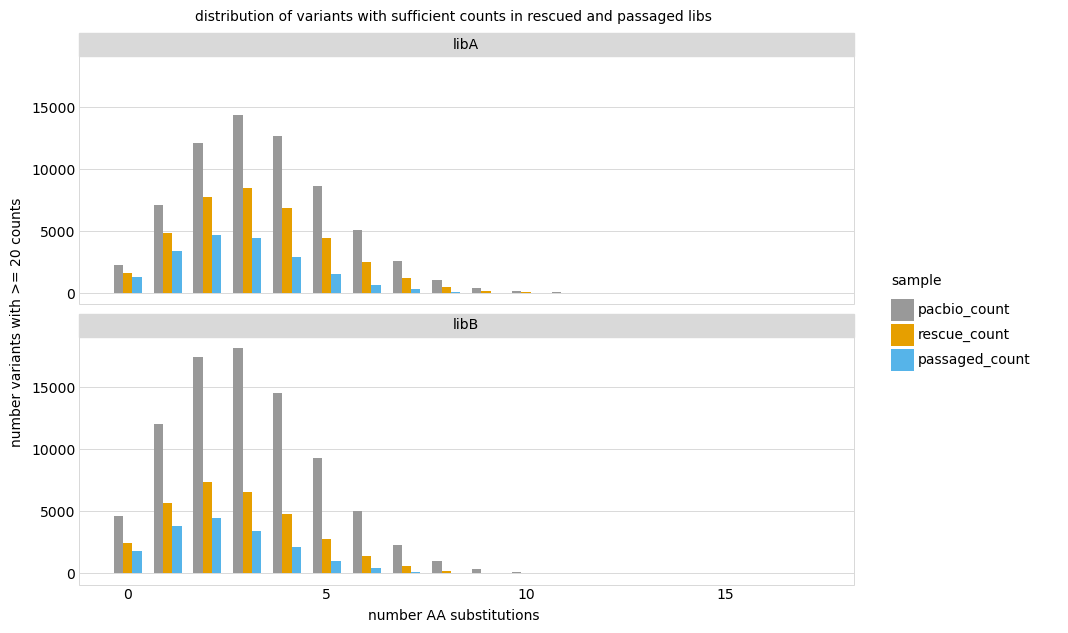

In [35]:
stratified_thresholded_variants['sample'] = pd.Categorical(
    stratified_thresholded_variants['sample'], categories=['pacbio_count', 'rescue_count', 'passaged_count'], ordered=True
)

p = (
    ggplot(
        stratified_thresholded_variants,
        aes(x='number_substitutions', y='thresholded_variants', fill='sample')
    ) +
    geom_bar(stat='identity', position=position_dodge(), width=0.7) +
    theme(figure_size=(10, 7),
         panel_grid_major_x=element_blank(),
         ) + 
    scale_fill_manual(values=CBPALETTE) +
    labs(x='number AA substitutions', 
         y='number variants with >= 20 counts', 
         title='distribution of variants with sufficient counts in rescued and passaged libs')
)

p = p + facet_wrap('~ library', nrow = 2)

_ = p.draw()

p.save('scratch_notebooks/220614_pool_selections/figures/thresholded_variant_distribution_pacbio.pdf')

In [31]:
percent_dropout = (stratified_thresholded_variants
                   .pivot(index=['number_substitutions', 'library'], columns='sample', values='thresholded_variants')
                   .reset_index()
                   .rename_axis(None, axis=1)
                  )

percent_dropout

,number_substitutions,library,pacbio_count,rescue_count,passaged_count
0,0,libA,2244.0,1658.0,1314.0
1,0,libB,4597.0,2457.0,1845.0
2,1,libA,7095.0,4824.0,3374.0
3,1,libB,12025.0,5660.0,3839.0
4,2,libA,12093.0,7715.0,4652.0
5,2,libB,17473.0,7369.0,4453.0
6,3,libA,14327.0,8506.0,4473.0
7,3,libB,18197.0,6606.0,3451.0
8,4,libA,12649.0,6863.0,2925.0
9,4,libB,14595.0,4830.0,2151.0


/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 12 x 5 in image.
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: scratch_notebooks/220614_pool_selections/figures/plasmid_vs_passaged_diversity.pdf
/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

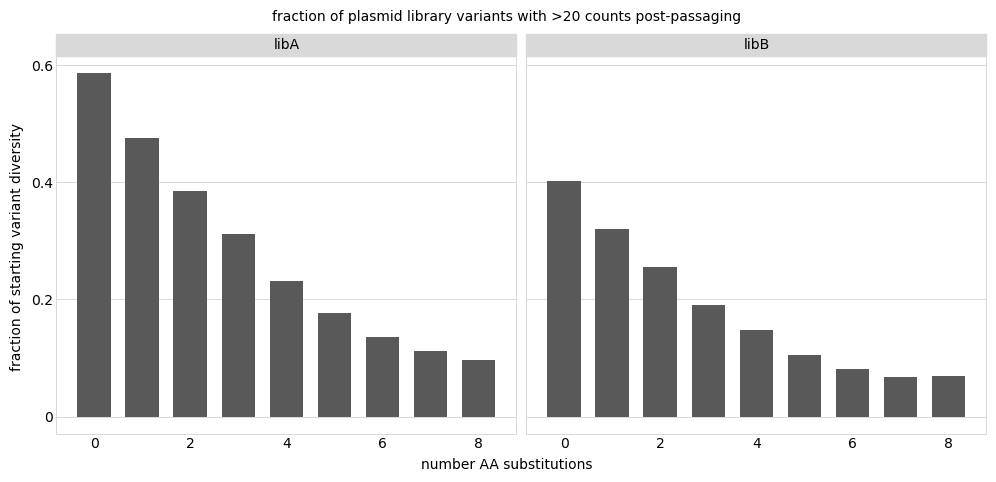

In [34]:
percent_dropout = (stratified_thresholded_variants
                   .pivot(index=['number_substitutions', 'library'], columns='sample', values='thresholded_variants')
                   .reset_index()
                   .rename_axis(None, axis=1)
                  )

percent_dropout['fraction_pacbio'] = percent_dropout['passaged_count'] / percent_dropout['pacbio_count']

percent_dropout = percent_dropout.loc[percent_dropout['number_substitutions'] < 9]

p = (
    ggplot(
        percent_dropout,
        aes(x='number_substitutions', 
            y='fraction_pacbio')
    ) +
    geom_bar(stat='identity', position=position_dodge(), width=0.7) +
    theme(figure_size=(12, 5),
         panel_grid_major_x=element_blank(),
         ) + 
    scale_fill_manual(values=CBPALETTE[2:]) +
    labs(x='number AA substitutions', 
         y='fraction of starting variant diversity', 
         title='fraction of plasmid library variants with >20 counts post-passaging')
)

p = p + facet_wrap('~ library', nrow = 1)

_ = p.draw()

p.save('scratch_notebooks/220614_pool_selections/figures/plasmid_vs_passaged_diversity.pdf')

### Do we just need to infect more wells?

Again, the problem is that we're filtering out ~80-90% of our library diversity on thresholding for variants with at least 20 counts in the no antibody controls. I'm trying to gauge whether this is a problem that can be solved by increasing the size of infections and/or getting more sequencing reads. Or whether the low abundance of most variants is inherently due to bottlenecking, in which case more reads isn't going to help.

On the 4-19-22 run, I had 2 infection replicates for libA. Try combining the counts from these replicates into a single no-antibody selection, and see how that effects thresholding.

In [ ]:
# check the no-antibody samples we have
no_ab_counts['sample'].unique()

In [ ]:
libA_220419_combined_counts = no_ab_counts[(no_ab_counts['library'] == 'libA') &
                                     (no_ab_counts['no-antibody_sample'] != '220606_1_no-antibody_control_1')
                                    ]

libA_220419_combined_counts = libA_220419_combined_counts.assign(
    total_counts=lambda x: x.groupby(['barcode'])['no-antibody_count'].transform('sum')
)

# this gives me a df with duplicated entries for each no Ab samples
# kind of hacky, but just cut it in half
libA_220419_combined_counts = (libA_220419_combined_counts
                               .loc[libA_220419_combined_counts['no-antibody_sample'] 
                                    == '220419_1_no-antibody_control_1']
                              )

# reduce to just the columns we care about
# libA_220419_combined_counts = libA_220419_combined_counts[[
#     'barcode', 'no_antibody_count_threshold', 'variant_above_threshold', 'sample', 'total_counts'
# ]]

libA_220419_combined_counts

In [ ]:
len(libA_220419_combined_counts.loc[libA_220419_combined_counts['variant_above_threshold'] == 0].index)
# len(libA_220419_combined_counts.loc[libA_220419_combined_counts['no-antibody_count'] == 0].index)

In [ ]:
number_below_threshold = len(libA_220419_combined_counts.loc[libA_220419_combined_counts['total_counts'] < 20].index)
number_zero = len(libA_220419_combined_counts.loc[libA_220419_combined_counts['total_counts'] == 0].index)

print(f'Variants with less than 20 counts in no Ab infections: {number_below_threshold}')
print(f'Variants with 0 counts in no Ab infections: {number_zero}')

In [ ]:
# plot the distribution of counts for variants below the threshold

libA_220419_combined_counts_threshold = (libA_220419_combined_counts.loc[libA_220419_combined_counts['total_counts'] < 20]
                               .reset_index(drop=True))

p = (
    ggplot(
        libA_220419_combined_counts_threshold,
        aes(x='total_counts')) + 
    geom_histogram() + 
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    labs(x='barcode counts', 
         y='number variants', title='distribution of barcode counts for variants below threshold in 220606 no-Ab infection')
) 

_ = p.draw()

In [ ]:
wt_no_ab_counts

In [ ]:
libA_rescue_counts

In [ ]:
wt_libA_rescue_counts = libA_rescue_counts.loc[libA_rescue_counts['aa_substitutions'].isna()]
wt_libA_rescue_counts

In [ ]:
wt_no_ab_counts = no_ab_counts.loc[(no_ab_counts['aa_substitutions_sequential'] == '') & 
                                   (no_ab_counts['sample'] == 'libA_220606_1_no-antibody_control_1')
                                  ]

p = (
    ggplot(
        wt_no_ab_counts,
        aes(x='no-antibody_count')) + 
    geom_histogram(binwidth=50) + 
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    labs(x='wildtype barcode count', y='number variants (all wt)', 
         title='wt barcode skew in passaged library')
)

_ = p.draw()

In [ ]:
wt_libA_rescue_counts = wt_libA_rescue_counts.loc[wt_libA_rescue_counts['count'] != 0]

p = (
    ggplot(
        wt_libA_rescue_counts,
        aes(x='count')) + 
    geom_histogram(binwidth=50) + 
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) +
    labs(x='wildtype barcode count', 
         y='number variants (all wt)', title='wt barcode skew in rescued library')
)

_ = p.draw()

In [ ]:
p = (
    ggplot(
        no_ab_counts_small,
        aes(x='no-antibody_count')) + 
    geom_histogram() + 
    theme(figure_size=(10, 5),
         panel_grid_major_x=element_blank(),
         ) + 
    scale_fill_manual(values=CBPALETTE[2:]))

# p = (
#     ggplot(no_ab_counts_small,
#            aes(x='barcode', y='no-antibody_count', fill='variant_above_threshold')) +
#     geom_bar(stat='identity') + 
#     theme(figure_size=(12, 5),
#          panel_grid_major_x=element_blank(),
#          ))
#     labs(x='unique_background_count', 
#          y='number_muts', title=f'{lib_id} variant background spread') +
#     scale_fill_manual(values=CBPALETTE[2:]))

_ = p.draw()


In [ ]:
prob_escape['antibody_sample'].unique()







In [ ]:
prob_escape_low_sele = prob_escape[(prob_escape['antibody_sample'] == '220606_1_antibody_AUSAB-13_0.0003675_1') & 
                                   (prob_escape['library'] == 'libA')
                                  ]
prob_escape_low_sele_high = prob_escape_low_sele[(prob_escape_low_sele['no-antibody_count'] <= 20) & 
                                                 (prob_escape_low_sele['antibody_count'] >= 20)
                                                ]
prob_escape_low_sele_high

### Try combining reps 1 and 2 of no Ab counts from 4-19-22 run

In [28]:
no_ab_counts

,library,no-antibody_sample,aa_substitutions_sequential,no-antibody_count,barcode,no_antibody_count_threshold,variant_above_threshold,count_above_threshold,sample
0,libA,220419_1_no-antibody_control_1,K297I,109937,ATAACACAAAAAAGTA,20,1,109937,libA_220419_1_no-antibody_control_1
1,libA,220419_1_no-antibody_control_1,Y113N T150K L263H V342Y,34226,AGACACTAAATACAGC,20,1,34226,libA_220419_1_no-antibody_control_1
2,libA,220419_1_no-antibody_control_1,K46A I301V E409M,31779,AAAAATCTGAGACAAA,20,1,31779,libA_220419_1_no-antibody_control_1
3,libA,220419_1_no-antibody_control_1,R111S V366M R402S,28257,TATCTACCTAACGAAA,20,1,28257,libA_220419_1_no-antibody_control_1
4,libA,220419_1_no-antibody_control_1,,30210,AGCCTATTAGGATTCG,20,1,30210,libA_220419_1_no-antibody_control_1
...,...,...,...,...,...,...,...,...,...
1480039,libB,220606_1_no-antibody_control_1,V45I D209Y I211T R280H T337V K387R S419P K491S...,3,TTTTTTGATTACCAGC,20,0,0,libB_220606_1_no-antibody_control_1
1480040,libB,220606_1_no-antibody_control_1,N152S H175A I211D Q216S K297F D310Q,0,TTTTTTTAAGACAAAC,20,0,0,libB_220606_1_no-antibody_control_1
1480041,libB,220606_1_no-antibody_control_1,Q216D S217C,0,TTTTTTTAGGCAATAA,20,0,0,libB_220606_1_no-antibody_control_1
1480042,libB,220606_1_no-antibody_control_1,K295N D310M,0,TTTTTTTTCCACTAAA,20,0,0,libB_220606_1_no-antibody_control_1


In [29]:
no_ab_counts['no-antibody_sample'].unique()

array(['220419_1_no-antibody_control_1', '220419_1_no-antibody_control_2',
       '220606_1_no-antibody_control_1'], dtype=object)

In [30]:
no_ab_combined_counts = no_ab_counts[(no_ab_counts['library'] == 'libA') &
                                     (no_ab_counts['no-antibody_sample'] != '220606_1_no-antibody_control_1')
                                    ]
# no_ab_combined_counts = (no_ab_combined_counts.groupby(['barcode'])
#                          .aggregate({'no-antibody_count': 'sum'})
#                         )

no_ab_combined_counts = no_ab_combined_counts.assign(
    total_counts=lambda x: x.groupby(['barcode'])['no-antibody_count'].transform('sum')
)

no_ab_combined_counts

,library,no-antibody_sample,aa_substitutions_sequential,no-antibody_count,barcode,no_antibody_count_threshold,variant_above_threshold,count_above_threshold,sample,total_counts
0,libA,220419_1_no-antibody_control_1,K297I,109937,ATAACACAAAAAAGTA,20,1,109937,libA_220419_1_no-antibody_control_1,233349
1,libA,220419_1_no-antibody_control_1,Y113N T150K L263H V342Y,34226,AGACACTAAATACAGC,20,1,34226,libA_220419_1_no-antibody_control_1,72098
2,libA,220419_1_no-antibody_control_1,K46A I301V E409M,31779,AAAAATCTGAGACAAA,20,1,31779,libA_220419_1_no-antibody_control_1,65580
3,libA,220419_1_no-antibody_control_1,R111S V366M R402S,28257,TATCTACCTAACGAAA,20,1,28257,libA_220419_1_no-antibody_control_1,60390
4,libA,220419_1_no-antibody_control_1,,30210,AGCCTATTAGGATTCG,20,1,30210,libA_220419_1_no-antibody_control_1,63211
...,...,...,...,...,...,...,...,...,...,...
399481,libA,220419_1_no-antibody_control_2,N57D I396L V509G,10,TTTTTTGAATTAAAAT,20,0,0,libA_220419_1_no-antibody_control_2,16
399482,libA,220419_1_no-antibody_control_2,T206N V509A,0,TTTTTTTCAAAATAAC,20,0,0,libA_220419_1_no-antibody_control_2,0
399483,libA,220419_1_no-antibody_control_2,T49E L176N A549S,0,TTTTTTTCTAAGGATC,20,0,0,libA_220419_1_no-antibody_control_2,1
399484,libA,220419_1_no-antibody_control_2,P23A V121I N141I S163D Y178L T179R H202E S212C...,0,TTTTTTTCTGAAGTAG,20,0,0,libA_220419_1_no-antibody_control_2,0


In [31]:
no_ab_combined_counts_thresholded = no_ab_combined_counts[(no_ab_combined_counts['total_counts'] >= 20) &
                                                   (no_ab_combined_counts['no-antibody_sample'] == '220419_1_no-antibody_control_1')
                                                  ].reset_index(drop=True)

no_ab_counts_thresholded = no_ab_combined_counts[(no_ab_combined_counts['variant_above_threshold'] == 1)&
                                                   (no_ab_combined_counts['no-antibody_sample'] == '220419_1_no-antibody_control_1')
                                                  ].reset_index(drop=True)

filtered_variants = [libA_passage_data[0], len(no_ab_counts_thresholded), len(no_ab_combined_counts_thresholded)]
column_headers = ['pacbio_total', 'no-ab_1_well', 'no-ab_2_wells']

In [32]:
lists = pd.Series([column_headers, filtered_variants])

combined_well_data = pd.DataFrame(item for item in lists)
combined_well_data =combined_well_data.rename(columns=combined_well_data.iloc[0]).drop(combined_well_data.index[0])

combined_well_data

,pacbio_total,no-ab_1_well,no-ab_2_wells
1,66581,21013,28598


In [ ]:
combined_well_data_tidy = combined_well_data.melt(
#     id_vars = ['library'], 
    value_vars = ['pacbio_total', 'no-ab_1_well', 'no-ab_2_wells'],
    var_name = 'variant_category',
    value_name = 'number_variants'
)

combined_well_data_tidy['number_variants'] = combined_well_data_tidy['number_variants'].astype(int)

In [ ]:
combined_well_data_tidy['variant_category'] = pd.Categorical(
    combined_well_data_tidy['variant_category'], categories=['pacbio_total', 'no-ab_1_well', 'no-ab_2_wells'], ordered=True
)

p = (
    ggplot(
        combined_well_data_tidy,
        aes(x='variant_category', y='number_variants', fill='variant_category')
    ) +
    geom_col(stat='identity', width=0.7, show_legend=False) +
#     scale_color_discrete(guide=False) +
#     coord_cartesian(ylim=(0, 70000)) +
    theme(figure_size=(6, 5),
         panel_grid_major_x=element_blank(),
         ) + 
    scale_fill_manual(values=CBPALETTE) +
    labs(x='',
         y='number variants', 
         title='number variants with sufficient counts from sequencing 1 vs 2 combined wells')
)

_ = p.draw()

p.save('scratch_notebooks/220614_pool_selections/figures/combined_wells.pdf')

In [ ]:
no_ab_counts